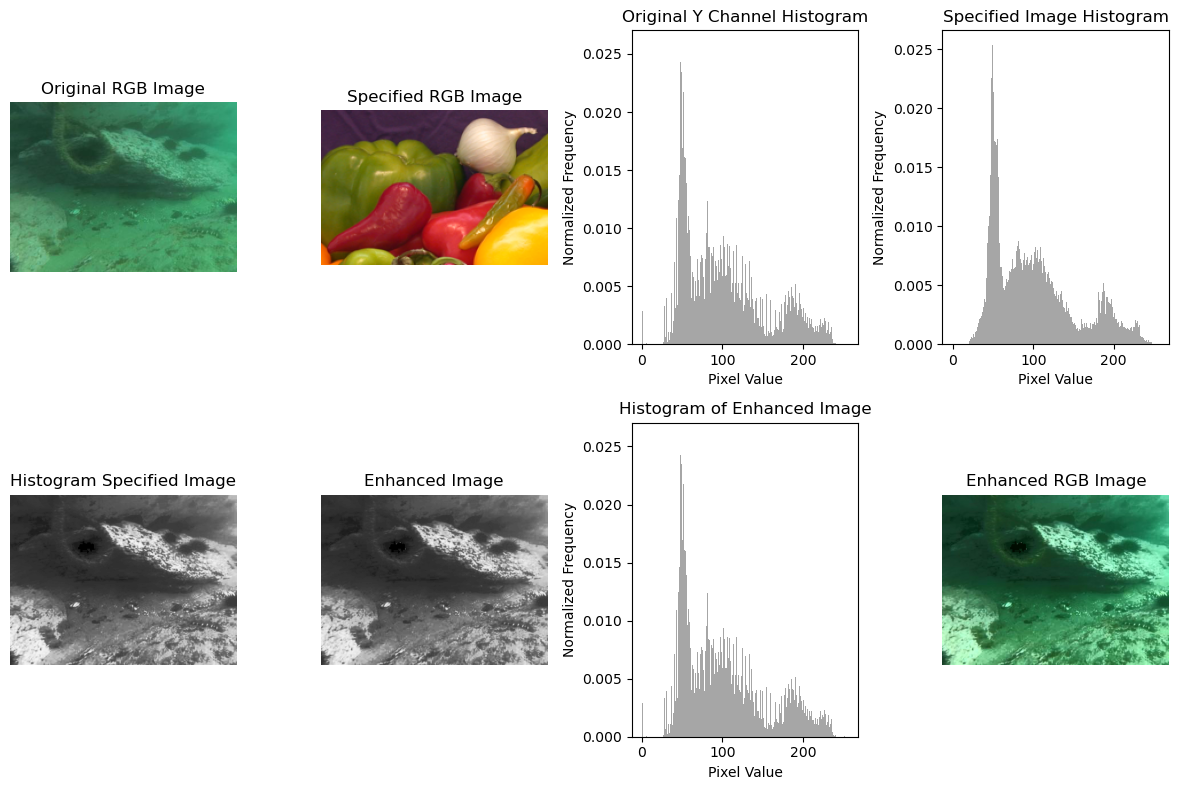

In [1]:
import numpy as np
from PIL import Image
import pywt
import matplotlib.pyplot as plt
from scipy.ndimage import zoom


# Histogram Specification Helper Functions
def match_histograms(c, c_tilde, z_q):
    k = 0
    new_values = np.zeros_like(c)
    for i in range(len(c)):
        while k < len(c_tilde) - 1 and c_tilde[k] < c[i]:
            k += 1
        new_values[i] = z_q[k]
    return new_values

def histogram_specification(original, specified):
    original_hist, bins = np.histogram(original.flatten(), 256, [0, 256])
    specified_hist, bins = np.histogram(specified.flatten(), 256, [0, 256])

    # Calculate the cumulative distribution function for both images
    cdf_original = original_hist.cumsum()
    cdf_specified = specified_hist.cumsum()

    # Normalize the CDFs
    cdf_original = (255 * cdf_original / cdf_original[-1]).astype(np.uint8)
    cdf_specified = (255 * cdf_specified / cdf_specified[-1]).astype(np.uint8)

    # Use the CDFs to map the pixel values from the original to the specified
    new_values = match_histograms(cdf_original, cdf_specified, bins[:-1])

    # Map the pixel values of the original image to create the new image
    result_image = new_values[original.ravel()].reshape(original.shape)
    return result_image

# Wavelet Transform Enhancement Functions
def threshold_coeffs(coeffs, threshold=10):
    cA, (cH, cS, cV) = coeffs
    cY_thresh = pywt.threshold(cV, threshold, mode='soft')
    return cA, (cH, cS, cY_thresh)

def enhance_image_through_wavelet(original_image, threshold=10):
    # Apply wavelet transform
    coeffs = pywt.dwt2(original_image, 'haar')
   
    # Enhance the coefficients with thresholding
    coeffs_thresh = threshold_coeffs(coeffs, threshold)
   
    # Reconstruct the image from the enhanced coefficients
    enhanced_image = pywt.idwt2(coeffs_thresh, 'haar')
   
    return np.uint8(enhanced_image)



if __name__ == "__main__":
    # Read the RGB image using PIL
    rgb_img = Image.open(r"C:\Users\iamsh\Desktop\Simple_DIP\Main_Project\UIQS\pic_C\JPEGImages\2370.jpg")

    # Convert RGB image to YUV color space
    yuv_img = rgb_img.convert('YCbCr')
    yuv_array = np.array(yuv_img)
    y_channel = yuv_array[:, :, 0]  # Extract Y channel

    # Read the specified image (to match the histogram)
    specified_img = Image.open(r"C:\Program Files\MATLAB\R2023a\toolbox\images\imdata\onion.png")
    specified_array = np.array(specified_img.convert('L'))

    # Perform Exact Histogram Specification on Y channel
    matched_array = histogram_specification(y_channel, specified_array)

    # Perform Image Enhancement with thresholding on Y channel
    enhanced_array = enhance_image_through_wavelet(matched_array, threshold=10)

    # Resize the enhanced array to match the shape of the Y channel
    enhanced_array_resized = zoom(enhanced_array, (y_channel.shape[0] / enhanced_array.shape[0], y_channel.shape[1] / enhanced_array.shape[1]))

    # Replace the Y channel in YUV image with the enhanced Y channel
    yuv_array[:, :, 0] = enhanced_array_resized

    # Convert YUV array back to RGB image
    enhanced_img = Image.fromarray(yuv_array, 'YCbCr').convert('RGB')

    # Plot the images and histograms using matplotlib
    plt.figure(figsize=(15, 8))

    plt.subplot(2, 5, 1)
    plt.title('Original RGB Image')
    plt.imshow(rgb_img)
    plt.axis('off')

    plt.subplot(2, 5, 9)
    plt.title('Enhanced RGB Image')
    plt.imshow(enhanced_img)
    plt.axis('off')

    plt.subplot(2, 5, 8)
    plt.title('Histogram of Enhanced Image')
    plt.hist(enhanced_array_resized.flatten(), bins=256, range=(0, 256), density=True, color='gray', alpha=0.7)
    plt.xlabel('Pixel Value')
    plt.ylabel('Normalized Frequency')

    plt.subplot(2, 5, 7)
    plt.title('Enhanced Image')
    plt.imshow(enhanced_array_resized, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 5, 3)
    plt.title('Original Y Channel Histogram')
    plt.hist(y_channel.flatten(), bins=256, range=(0, 256), density=True, color='gray', alpha=0.7)
    plt.xlabel('Pixel Value')
    plt.ylabel('Normalized Frequency')

    plt.subplot(2, 5, 4)
    plt.title('Specified Image Histogram')
    plt.hist(specified_array.flatten(), bins=256, range=(0, 256), density=True, color='gray', alpha=0.7)
    plt.xlabel('Pixel Value')
    plt.ylabel('Normalized Frequency')

    plt.subplot(2, 5, 6)
    plt.title('Matched Image Histogram')
    plt.hist(matched_array.flatten(), bins=256, range=(0, 256), density=True, color='gray', alpha=0.7)
    plt.xlabel('Pixel Value')
    plt.ylabel('Normalized Frequency')

    plt.subplot(2, 5, 6)
    plt.title('Histogram Specified Image')
    plt.imshow(matched_array, cmap='gray')
    plt.axis('off')
    
    plt.subplot(2, 5, 2)
    plt.title('Specified RGB Image')
    plt.imshow(specified_img)
    plt.axis('off')

    plt.tight_layout()
    plt.show()